In [1]:
%pylab inline
from pycheops import Dataset
from uncertainties import ufloat
from pycheops.constants import R_SunN, c

Populating the interactive namespace from numpy and matplotlib


### Create and instance of the dataset


*Run pycheops.core.setup_config once first to create the configuration file and data cache directory*


```python
>>> from pycheops.core import setup_config
>>> setup_config()
```
There are 3 ways to load a dataset

1. Use a .zip file already downloaded and save in the local data cache directory, e.g., 
```python
>>> dataset = Dataset('CH_PR900048_TG001701_V0000')
```

2. Download an example data set, e.g., 
```python
>>> ataset=Dataset.from_test_data('DP-080', target='EBLM J0113+31')
```

3. Download the simulated data from CHEOPsim ftp site using the run number, e.g., 
```python
>>> dataset = Dataset.from_simulation(7798, target='EBLM J0113+31')
```

**N.B.** CHEOPsim output is removed from the FTP server after some time so option 2 may not work for simulations done some time ago.
```

In [2]:
#dataset = Dataset.from_simulation(7798, target='EBLM J0113+31')
dataset=Dataset.from_test_data('DP-080', target='EBLM J0113+31')
#dataset = Dataset('CH_PR900048_TG001701_V0000', target='EBLM J0113+31')

_ = dataset.get_lightcurve(aperture='OPTIMAL')

/Users/pflm/pycheops_data/CH_PR900048_TG001701.zip already downloaded
Writing Imagette data to .tgz file...
Writing Lightcurve data to .tgz file...
.. CH_PR900048_TG001701_TU2020-10-06T04-32-50_SCI_COR_Lightcurve-DEFAULT_V0000.fits - done
.. CH_PR900048_TG001701_TU2020-10-06T04-32-50_SCI_COR_Lightcurve-OPTIMAL_V0000.fits - done
.. CH_PR900048_TG001701_TU2020-10-06T04-32-50_SCI_COR_Lightcurve-RINF_V0000.fits - done
.. CH_PR900048_TG001701_TU2020-10-06T04-32-50_SCI_COR_Lightcurve-RSUP_V0000.fits - done
Found archive tgzfile /Users/pflm/pycheops_data/CH_PR900048_TG001701_V0000.tgz
 PI name     : CHEOPSim
 OBS ID      : 7798
 Target      : EBLM J0113+31
 Coordinates : 01:13:51.33 +31:49:10.1
Light curve data loaded from  /Users/pflm/pycheops_data/CH_PR900048_TG001701_V0000-OPTIMAL.fits
Time stored relative to BJD = 2459128
Aperture radius used = 30 arcsec
C_cut = 10105445
N(C > C_cut) = 9
Mean counts = 10091488.2
Median counts = 10091105.2
RMS counts = 5175.5 [513 ppm]
Median standard erro

### Least-squares fit

Light curve for the eclipse of a planet/star of radius $R_p$ by a star of radius $R_s$.
The depth of the eclipse is L. The geometry of the system is defined by the properties of the transit, as follows.

- T_0:   time of mid-transit (BJD relative to dataset.bjd_ref)
- P:     orbital period (days)
- D:     transit depth, $(R_p/R_s)^2 = k^2$
- W:     transit width, $(R_s/a)\sqrt{(1+k)^2 - b^2}/\pi$
- b:     impact parameter, $a\sin(i)/R_s$
- L:     Eclipse depth
- a_c:   Light time travel across the orbit (days)
- c:     flux scaling factor
- f_c:   $\sqrt{e}\cos(\omega)$  (N.B. $\omega$ for primary star's orbit).
- f_s:   $\sqrt{e}\sin(\omega)$

Model options available here are 
 - linear or quadratic decorrelation against position (dfdx, dfdy, df2dx2, d2fdxdy, d2fdx2, d2fdy2)
 - linear decorrelation against roll angle (dfdsinphi, dfdcosphi)
 - linear or quadratic time trend (dfdt, d2fdt2)
 
Parameters and their bounds/priors are  specified as follows.

- as a floating point number for fixed parameters, e.g., "P=1.234".
- as a tuple for a free parameter with bounds, e.g., "L = (1e-6,0.1)" or "c = (0.9, 1.0, 1.1)". The median value of the tuple is used as the initial value in the fit.
- as a ufloat floating-point value with a standard error, e.g., "P=ufloat(1.2345,0.0001)", to specify a free parameter with a Gaussian prior.
- as an lmfit Parameter, e.g., "lmfit.Parameter(value=0.01,min=0.001,max=0.1,vary=True)"

The output from this method is an lmfit [MinimizerResult](https://lmfit.github.io/lmfit-py/fitting.html#minimizerresult-the-optimization-result) object.

The eclipse does not contain information on the parameters D, P, etc. so we fix these parameters in the fit or constrain them by priors.
 

In [3]:
BJD_0 = 2456023.26988
P = 14.2769001
E = round((dataset.bjd_ref-BJD_0)/P)
T_0 = ufloat(BJD_0 + P*E - dataset.bjd_ref,0.0002)
D = 0.02300
W = 0.01890391
b = 0.299
f_c = 0.08707092 
f_s = -0.54974417 
a_c = 25.808*R_SunN/c/86400  # Light travel time across the orbit in days

result = dataset.lmfit_eclipse(T_0=T_0, P=P, D=D, W=W, b=b, L=(0.0001,0.1),
                               f_c=f_c, f_s=f_s, a_c= a_c,                             
                               dfdsinphi=(-1,1),dfdcosphi=(-1,1))
print(dataset.lmfit_report())

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 980
    # variables        = 5
    chi-square         = 1535.16852
    reduced chi-square = 1.57453182
    Akaike info crit   = 449.866012
    Bayesian info crit = 474.303775
[[Variables]]
    T_0:       -6.64279904 +/- 2.5068e-04 (0.00%) (init = -6.642798)
    P:          14.2769 (fixed)
    D:          0.023 (fixed)
    W:          0.01890391 (fixed)
    b:          0.299 (fixed)
    L:          2.4595e-04 +/- 3.0896e-05 (12.56%) (init = 0.05005)
    f_c:        0.08707092 (fixed)
    f_s:       -0.5497442 (fixed)
    c:          1.00014725 +/- 1.8890e-05 (0.00%) (init = 1)
    a_c:        0.0006931734 (fixed)
    dfdsinphi:  3.7446e-04 +/- 1.6170e-05 (4.32%) (init = 0)
    dfdcosphi: -1.0289e-04 +/- 2.9811e-05 (28.97%) (init = 0)
    k:          0.15165751 +/- 0.00000000 (0.00%) == 'sqrt(D)'
    aR:         18.7270014 +/- 0.00000000 (0.00%) == 'sqrt((1+k)**2-b**2)/W/pi'
    e:   

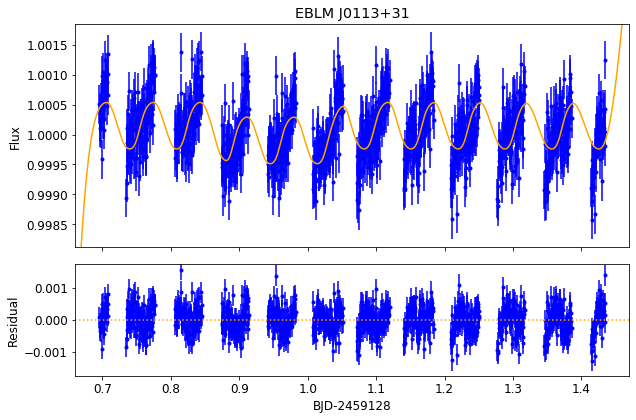

In [4]:
fig = dataset.plot_lmfit(title=dataset.target,figsize=(9,6),fontsize=12)


#### Plot fit with position/roll-angle trends removed


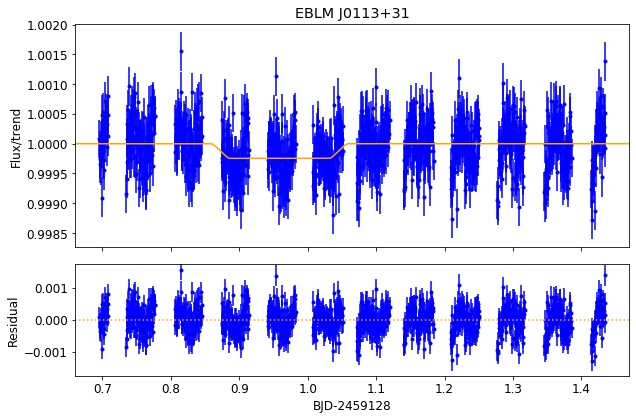

In [5]:
fig = dataset.plot_lmfit(title=dataset.target, detrend=True,
                         figsize=(9,6),fontsize=12)


### Sampling the posterior
Sampling the posterior probability distribution using the affine-invariant sampler [emcee](https://emcee.readthedocs.io/en/stable/). 

The $\pm$1-sigma limits on parameters from the prior are indicated in the corner plot using dashed lines.

This return value from emcee_transit is an instance of an [EnsembleSampler](https://emcee.readthedocs.io/en/latest/user/sampler/) object.

In [6]:
sampler = dataset.emcee_sampler()
print(dataset.emcee_report())

Running burn-in ..


100%|██████████| 256/256 [01:01<00:00,  4.16it/s]

Running sampler ..



100%|██████████| 512/512 [02:02<00:00,  4.17it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 32768
    # data points      = 979
    # variables        = 6
    chi-square         = 1535.41676
    reduced chi-square = 1.57802339
    Akaike info crit   = -12505.3222
    Bayesian info crit = -12476.0030
[[Variables]]
    T_0:       -6.64279709 +/- 1.9051e-04 (0.00%) (init = -6.642798)
    P:          14.2769 (fixed)
    D:          0.023 (fixed)
    W:          0.01890391 (fixed)
    b:          0.299 (fixed)
    L:          2.4669e-04 +/- 3.2451e-05 (13.15%) (init = 0.05005)
    f_c:        0.08707092 (fixed)
    f_s:       -0.5497442 (fixed)
    c:          1.00014783 +/- 1.8994e-05 (0.00%) (init = 1)
    a_c:        0.0006931734 (fixed)
    dfdsinphi:  3.7515e-04 +/- 1.6090e-05 (4.29%) (init = 0)
    dfdcosphi: -1.0408e-04 +/- 2.9313e-05 (28.16%) (init = 0)
    k:          0.15165751 +/- 0.00000000 (0.00%) == 'sqrt(D)'
    aR:         18.7270014 +/- 0.00000000 (0.00%) == 'sqrt((1+k)**2-b**2)/W/pi'
    e:

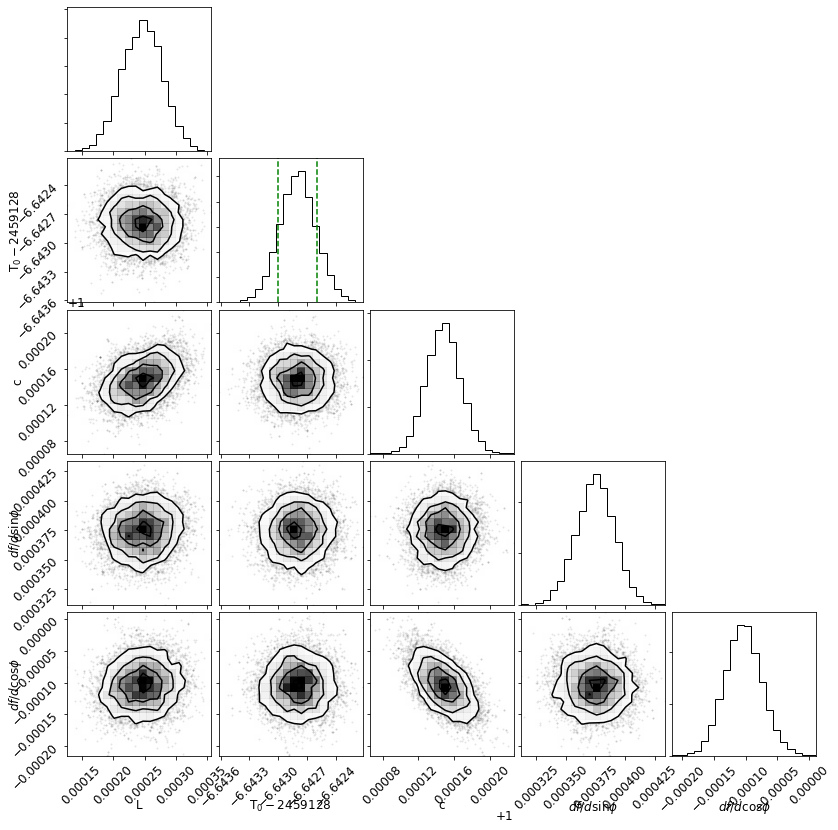

In [7]:
cornerplot = dataset.corner_plot(['L','T_0','c','dfdsinphi','dfdcosphi'])

#### Plot fit with position/roll-angle trends removed


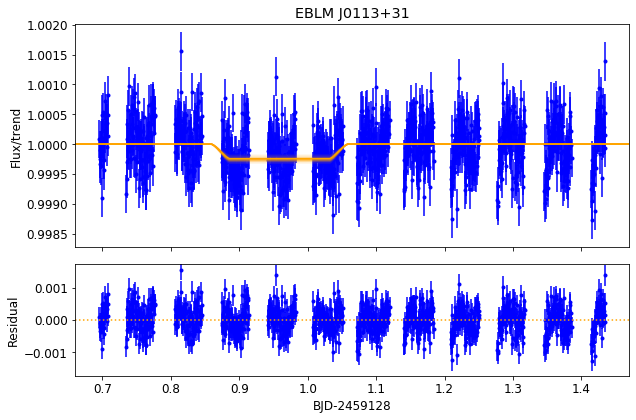

In [8]:
fig = dataset.plot_emcee(title=dataset.target,detrend=True,
                         figsize=(9,6),fontsize=12)

### Add correlated noise

Now use "add_shoterm=True" so that correlated noise is modelled using the SHOTerm kernel from [celerite](https://celerite.readthedocs.io/en/stable/). By default the parameter quality factor is fixed at $Q=1/\sqrt{2}$ so that the kernel is the one commonly used to model granulation noise
$$ k(\tau) = \omega_0 e^{-\omega_0\tau/\sqrt{2}}\cos\left(-\omega_0\tau/\sqrt{2} - \pi/4\right)$$

Priors on log_sigma, log_omega0 and log_S0 are from a previous run of this sampler without priors. Used here to remove long tails in the distrubtions with very few samples  that mess up the plots.

In [9]:
sampler = dataset.emcee_sampler(add_shoterm=True, log_sigma=ufloat(-9,1), 
                                log_omega0=ufloat(5,2), log_S0=ufloat(-20,2))
print(dataset.emcee_report())

Running burn-in ..


100%|██████████| 256/256 [01:17<00:00,  3.29it/s]

Running sampler ..



100%|██████████| 512/512 [02:31<00:00,  3.37it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 32768
    # data points      = 979
    # variables        = 8
    chi-square         = 1566.67921
    reduced chi-square = 1.61346984
    Akaike info crit   = -12652.0489
    Bayesian info crit = -12612.9566
[[Variables]]
    T_0:        -6.64279787 +/- 2.0094e-04 (0.00%) (init = -6.642798)
    P:           14.2769 (fixed)
    D:           0.023 (fixed)
    W:           0.01890391 (fixed)
    b:           0.299 (fixed)
    L:           2.2604e-04 +/- 8.5848e-05 (37.98%) (init = 0.05005)
    f_c:         0.08707092 (fixed)
    f_s:        -0.5497442 (fixed)
    c:           1.00011076 +/- 4.8394e-05 (0.00%) (init = 1)
    a_c:         0.0006931734 (fixed)
    dfdsinphi:   4.2792e-04 +/- 4.6047e-05 (10.76%) (init = 0)
    dfdcosphi:  -3.1735e-05 +/- 7.8916e-05 (248.67%) (init = 0)
    k:           0.15165751 +/- 0.00000000 (0.00%) == 'sqrt(D)'
    aR:          18.7270014 +/- 0.00000000 (0.00%) == 'sqrt((1+k)**2-b*

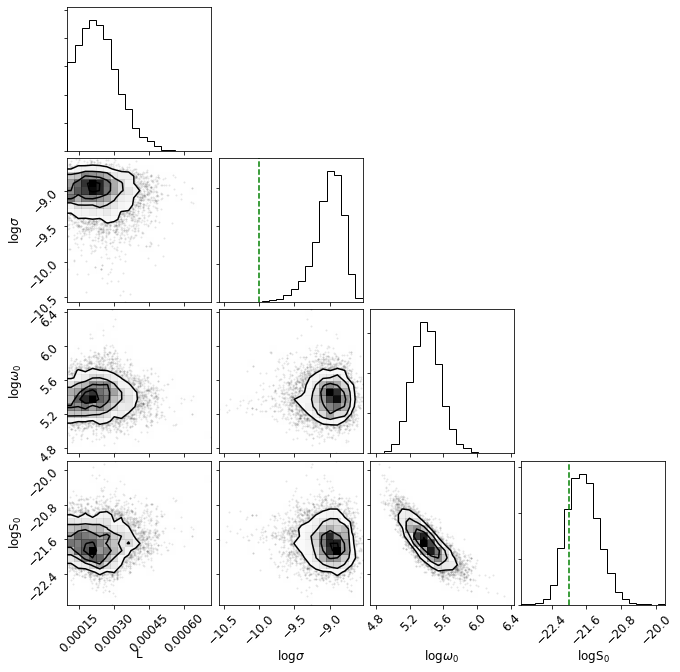

In [10]:
cornerplot = dataset.corner_plot(['L','log_sigma','log_omega0','log_S0'])

#### Light curve fit with trends removed

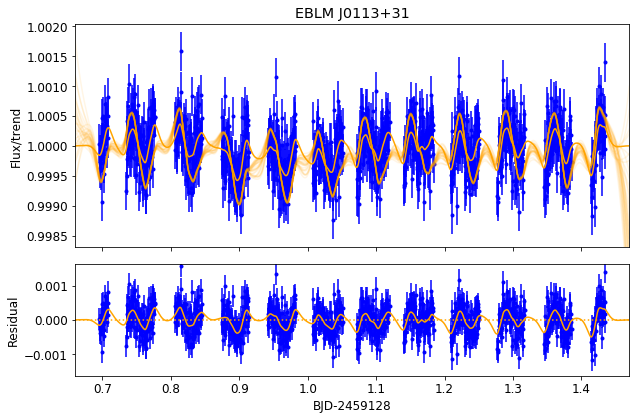

In [11]:
fig = dataset.plot_emcee(title=dataset.target,detrend=True,
                         figsize=(9,6),fontsize=12)

(c) 2019 Pierre Maxted, Keele Univerity, UK